In [5]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import h5py
import sys
import os
from absco_lookup import load_absco_file
from mie import mie_phase_function
from retrieval import ForwardFunction, Retrieval, calculate_Xgas, calculate_n_dry_air
import settings as s
from copy import deepcopy

#### Default settings can be found in settings.py, e.g.:

Band limits:
*   0.76 um O$_2$ A-band
*   1.60 um CO$_2$ band
*   1.65 um CH$_4$ band

#### Load ABSCO tables:

In [6]:
absco_data = load_absco_file(os.path.join(s.ABSCO_TABLE_FOLDER, "absco.h5"))

#### (1) Use our true values to model some radiances. Initially not including aerosols:

In [7]:
model_true = ForwardFunction(
    absco_data=absco_data,
    measurement_error=True #Add noise
    )

#### Plot true radiances:

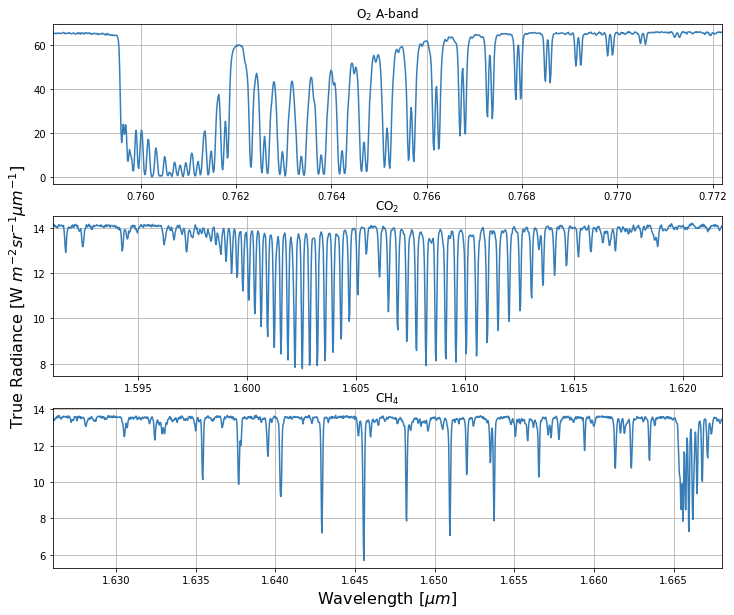

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(12,10))
ax[0].plot(model_true.band_wl[0], model_true.R_band[0],c='#377eb8')
ax[0].set_xlim(min(model_true.band_wl[0]),max(model_true.band_wl[0]))
ax[0].set_title("O"+r'$_2$'+" A-band")
ax[0].grid(True)
ax[1].plot(model_true.band_wl[1], model_true.R_band[1],c='#377eb8')
ax[1].set_xlim(min(model_true.band_wl[1]),max(model_true.band_wl[1]))
ax[1].set_ylabel('True Radiance [W '+r'$m^{-2}$'+r'$ sr^{-1}$'+r'$\mu m^{-1}$'+']',size=16)
ax[1].set_title("CO"+r'$_2$')
ax[1].grid(True)
ax[2].plot(model_true.band_wl[2], model_true.R_band[2],c='#377eb8')
ax[2].set_xlim(min(model_true.band_wl[2]),max(model_true.band_wl[2]))
ax[2].set_title("CH"+r'$_4$')
ax[2].set_xlabel('Wavelength ['+r'$\mu m$'+']',size=16)
ax[2].grid(True)

#### Use our prior values to create some modeled radiances:

In [9]:
model_prior = ForwardFunction(
    absco_data=absco_data,
    co2=s.co2_prior,
    ch4=s.ch4_prior,
    T=s.T_prior,
    p=s.p_prior,
    q=s.q_prior,
    albedo=s.albedo_prior,
    )

#### Plot the residuals between the prior modeled radiances and the true radiances:

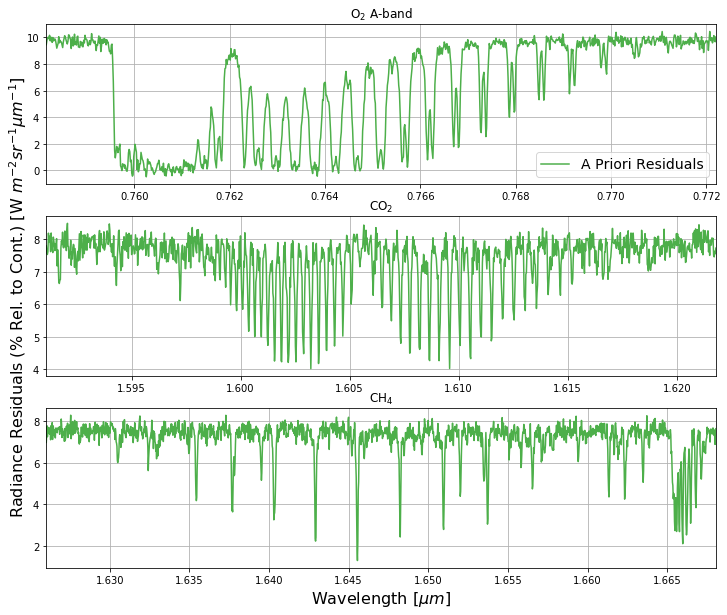

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(12,10))
ax[0].plot(model_true.band_wl[0], (model_prior.R_band[0] - model_true.R_band[0])/(model_true.R_band[0].max())*100.,label="A Priori Residuals",c='#4daf4a')
ax[0].set_xlim(min(model_true.band_wl[0]),max(model_true.band_wl[0]))
ax[0].set_title("O"+r'$_2$'+" A-band")
ax[0].grid(True)
ax[0].legend(loc="lower right",fontsize=14)
ax[1].plot(model_true.band_wl[1], (model_prior.R_band[1] - model_true.R_band[1])/(model_true.R_band[1].max())*100.,c='#4daf4a')
ax[1].set_xlim(min(model_true.band_wl[1]),max(model_true.band_wl[1]))
ax[1].set_ylabel('Radiance Residuals (% Rel. to Cont.) [W '+r'$m^{-2}$'+r'$ sr^{-1}$'+r'$\mu m^{-1}$'+']',size=16)
ax[1].set_title("CO"+r'$_2$')
ax[1].grid(True)
ax[2].plot(model_true.band_wl[2], (model_prior.R_band[2] - model_true.R_band[2])/(model_true.R_band[2].max())*100.,c='#4daf4a')
ax[2].set_xlim(min(model_true.band_wl[2]),max(model_true.band_wl[2]))
ax[2].set_title("CH"+r'$_4$')
ax[2].set_xlabel('Wavelength ['+r'$\mu m$'+']',size=16)
ax[2].grid(True)

#### Set up the retrieval inputs as a dictionary. Prior state vector ($\mathbf{x}$):

*   Multiplicative scaling factor on the a priori CO2 profile, start at 1 (no change).
*   Multiplicative scaling factor on the a priori CH4 profile, start at 1 (no change).
*   Additive scaling factor on the a priori temperature profile, start at 0 (no change).
*   Multiplicative scaling factor on the a prior pressure profile, start at 1 (no change).
*   Multiplicative scaling factor on the a priori specific humidity profile, start at 1 (no change).
*   Band 1 albedo (start at a priori)
*   Band 2 albedo (start at a priori)
*   Band 3 albedo (start at a priori)
*   Aerosol optical depth (start at a priori)

In [11]:
x = {}
x["prior"] = np.array([
  1, #Multiplicative scaling factor on the prior CO2 profile, start at 1 (no change).
  1, #Multiplicative scaling factor on the prior CH4 profile, start at 1 (no change).
  0, #Additive scaling factor on the prior temperature profile, start at 0 (no change).
  1, #Multiplicative scaling factor on the prior pressure profile, start at 1 (no change).
  1, #Multiplicative scaling factor on the prior specific humidity profile, start at 1 (no change).
  model_prior.albedo[0], #Band 1 albedo (start at prior)
  model_prior.albedo[1], #Band 2 albedo (start at prior)
  model_prior.albedo[2]]) #Band 3 albedo (start at prior)
x["names"] = ["CO2 Profile Multiplicative Offset","CH4 Profile Multiplicative Offset", "Temperature Profile Additive Offset","Pressure Profile Multiplicative Offset","Specific Humidity Profile Multiplicative Offset","Albedo Band 1","Albedo Band 2","Albedo Band 3"]
x["true"] = np.array([model_true.co2[0]/model_prior.co2[0], model_true.ch4[0]/model_prior.ch4[0], model_true.T[0] - model_prior.T[0], model_true.p[0]/model_prior.p[0], model_true.q[0]/model_prior.q[0], model_true.albedo[0], model_true.albedo[1], model_true.albedo[2]]) # Calculate the true state vector values
x["S_prior"] = s.S_prior

#### Run the retrieval:

In [12]:
ret = Retrieval()
ret.run(x, model_prior, model_true, absco_data)

-----------------------------------------------------------------------------------------------------------------------
State vector:
Name                                              Prior  True
CO2 Profile Multiplicative Offset                 1.0    1.0101010101010102  
CH4 Profile Multiplicative Offset                 1.0    0.9523809523809524  
Temperature Profile Additive Offset               0.0    -2.0                
Pressure Profile Multiplicative Offset            1.0    0.9803921568627451  
Specific Humidity Profile Multiplicative Offset   1.0    0.9523809523809523  
Albedo Band 1                                     0.22   0.2                 
Albedo Band 2                                     0.27   0.25                
Albedo Band 3                                     0.28   0.26                
-----------
Reduced chisq =  858.3355511832355
Reduced chisq is not small enough yet, so update the state vector
Updated state vector (iteration 1):
Name                           

#### Get the radiances of the retrieved state for plotting:

In [13]:
model_ret = Retrieval.forward_model(ret, x, model_prior, absco_data, jacobians=True)

#### Plot the residuals between the posterior modeled radiances and the true radiances:

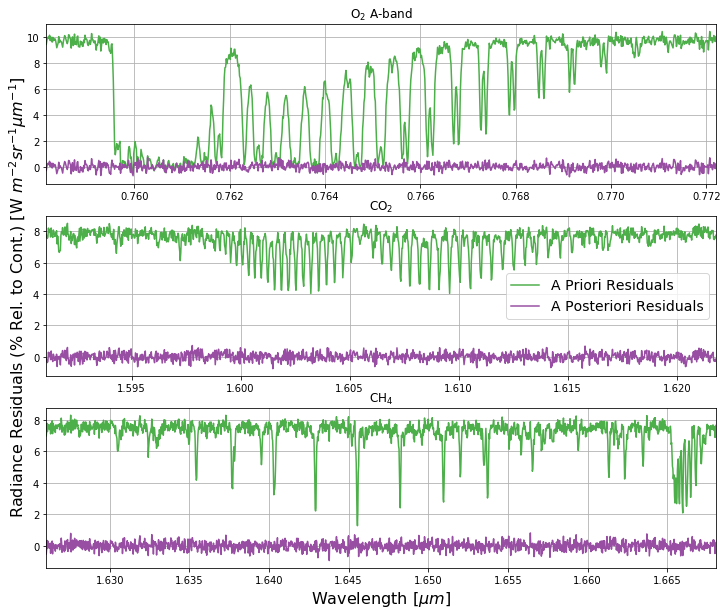

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(12,10))
ax[0].plot(model_true.band_wl[0], (model_prior.R_band[0] - model_true.R_band[0])/(model_true.R_band[0].max())*100.,c='#4daf4a')
ax[0].plot(model_true.band_wl[0], (model_ret.R_band[0] - model_true.R_band[0])/(model_true.R_band[0].max())*100.,c='#984ea3')
ax[0].set_xlim(min(model_true.band_wl[0]),max(model_true.band_wl[0]))
ax[0].set_title("O"+r'$_2$'+" A-band")
ax[0].grid(True)
ax[1].plot(model_true.band_wl[1], (model_prior.R_band[1] - model_true.R_band[1])/(model_true.R_band[1].max())*100.,label="A Priori Residuals",c='#4daf4a')
ax[1].plot(model_true.band_wl[1], (model_ret.R_band[1] - model_true.R_band[1])/(model_true.R_band[1].max())*100.,label="A Posteriori Residuals",c='#984ea3')
ax[1].set_xlim(min(model_true.band_wl[1]),max(model_true.band_wl[1]))
ax[1].set_ylabel('Radiance Residuals (% Rel. to Cont.) [W '+r'$m^{-2}$'+r'$ sr^{-1}$'+r'$\mu m^{-1}$'+']',size=16)
ax[1].set_title("CO"+r'$_2$')
ax[1].grid(True)
ax[1].legend(loc="center right",fontsize=14)
ax[2].plot(model_true.band_wl[2], (model_prior.R_band[2] - model_true.R_band[2])/(model_true.R_band[2].max())*100.,c='#4daf4a')
ax[2].plot(model_true.band_wl[2], (model_ret.R_band[2] - model_true.R_band[2])/(model_true.R_band[2].max())*100.,c='#984ea3')
ax[2].set_xlim(min(model_true.band_wl[2]),max(model_true.band_wl[2]))
ax[2].set_title("CH"+r'$_4$')
ax[2].set_xlabel('Wavelength ['+r'$\mu m$'+']',size=16)
ax[2].grid(True)

#### Plot the a posteriori correlation matrix:

Correlation matrix (R) condition number = 5.751


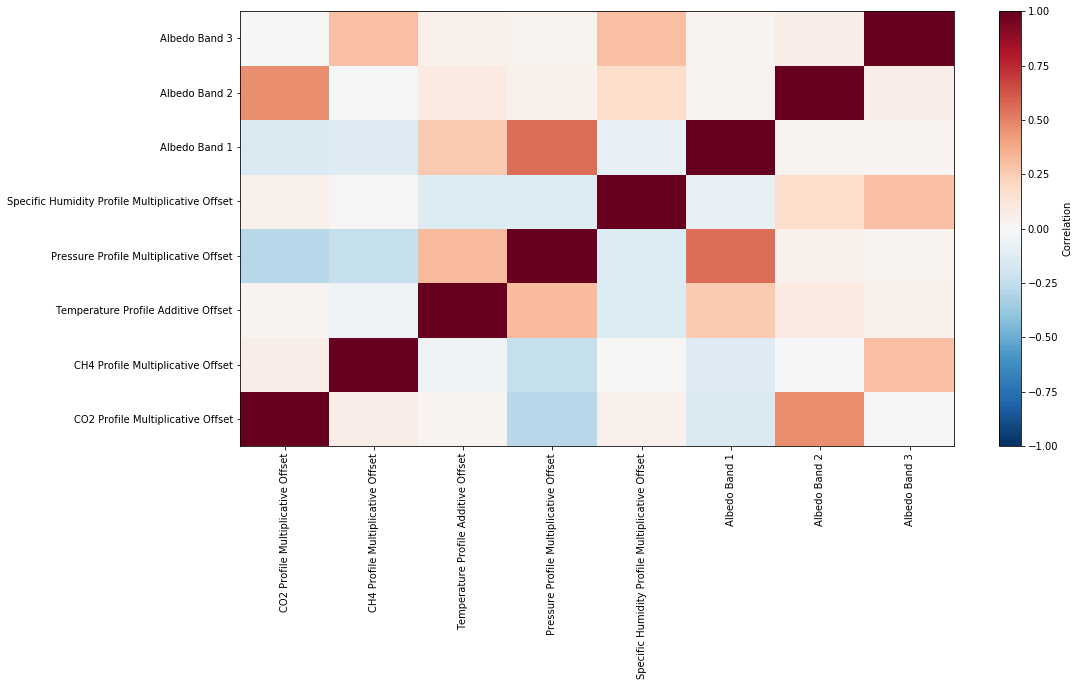

In [15]:
R = np.zeros((len(x["names"]),len(x["names"])))
for i in range(len(x["names"])):
  for j in range(len(x["names"])):
    if i==j: R[i,j] = 1
    else: R[i,j] = ret.S[i,j] / ret.S[i,i]**0.5 / ret.S[j,j]**0.5

fig = plt.figure(figsize=(16,8))
im1=plt.pcolormesh(R,vmin=-1,vmax=1,cmap=plt.cm.RdBu_r)
plt.yticks(ticks=np.linspace(0.5,0.5*len(x["names"])*2-0.5,len(x["names"])),labels=x["names"])
plt.xticks(ticks=np.linspace(0.5,0.5*len(x["names"])*2-0.5,len(x["names"])),labels=x["names"], rotation=90)
cbar=plt.colorbar()
cbar.set_label("Correlation")

Eigs = np.linalg.eigvals(R)
cond = np.max(Eigs)/np.min(Eigs)
print("Correlation matrix (R) condition number =",'{:.3f}'.format(cond))

#### Calculate and plot the averaging kernels for the gases:

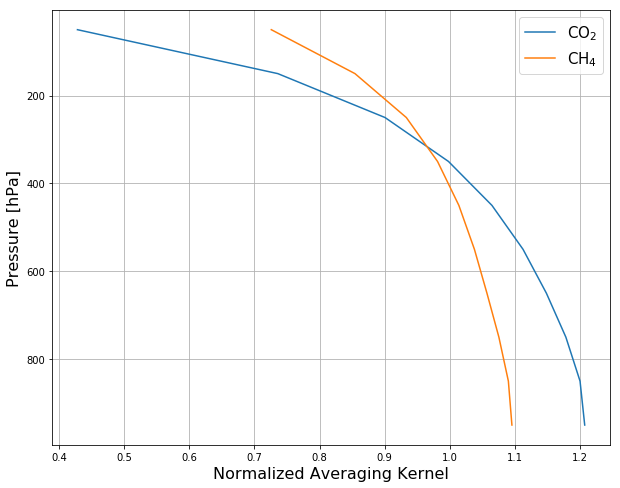

In [16]:
#Calculate the gain matrix
ret.G = LA.inv((ret.K.T).dot(model_true.Sy_inv).dot(ret.K) + LA.inv(x["S_prior"])).dot(ret.K.T).dot(model_true.Sy_inv)

#Calculate the normalized gas averaging kernels
ret.Ak_co2_norm = model_prior.xco2 * np.matmul(ret.G[0,:],model_ret.y_co2)/model_ret.h *1e-6
ret.Ak_ch4_norm = model_prior.xch4 * np.matmul(ret.G[1,:],model_ret.y_ch4)/model_ret.h *1e-9

#Plot
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(ret.Ak_co2_norm,model_prior.p_layer*x["ret"][3]/100.,label="CO"+r'$_2$')
ax.plot(ret.Ak_ch4_norm,model_prior.p_layer*x["ret"][3]/100.,label="CH"+r'$_4$')
ax.set_xlabel("Normalized Averaging Kernel",size=16)
ax.set_ylabel("Pressure [hPa]",size=16)
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc="upper right",fontsize=15)

#### Things to ponder for (1):
*   What are the Xgas errors? Are they within the posterior uncertainties?
*   Is the final chisq close to unity?
*   What do the spectral residuals look like?
*   Where are the CO2 and CH4 averaging kernels most sensitive?
*   What does the posterior correlation matrix look like? Why are certain elements correlated with each other?

#### (2) Now add aerosols to the true state but don't retrieve them:

In [17]:
#Calculate Mie scattering
P_aerosol, ssa_aerosol, qext_aerosol = mie_phase_function()

model_true_with_aerosols = ForwardFunction(
    absco_data=absco_data,
    P_aerosol=P_aerosol,
    ssa_aerosol=ssa_aerosol,
    qext_aerosol=qext_aerosol,
    measurement_error=True,
    tau_aerosol=0.10
    )

model_prior = ForwardFunction(
    absco_data=absco_data,
    co2=s.co2_prior,
    ch4=s.ch4_prior,
    T=s.T_prior,
    p=s.p_prior,
    q=s.q_prior,
    albedo=s.albedo_prior,
    tau_aerosol=None
    )

#Just copy the initial state vector
x_true_aerosols = {}
x_true_aerosols["prior"] = deepcopy(x["prior"])
x_true_aerosols["names"] = deepcopy(x["names"])
x_true_aerosols["true"] = deepcopy(x["true"])
x_true_aerosols["S_prior"] = deepcopy(x["S_prior"])

#Pass our prior without aerosols, but the true state with aerosols
ret_true_aerosols = Retrieval()
ret_true_aerosols.run(x_true_aerosols, model_prior, model_true_with_aerosols, absco_data)

#Grab the radiances of the retrieved state for plotting
model_ret_true_aerosols = Retrieval.forward_model(ret_true_aerosols, x_true_aerosols, model_prior, absco_data, jacobians=True)

-----------------------------------------------------------------------------------------------------------------------
State vector:
Name                                              Prior  True
CO2 Profile Multiplicative Offset                 1.0    1.0101010101010102  
CH4 Profile Multiplicative Offset                 1.0    0.9523809523809524  
Temperature Profile Additive Offset               0.0    -2.0                
Pressure Profile Multiplicative Offset            1.0    0.9803921568627451  
Specific Humidity Profile Multiplicative Offset   1.0    0.9523809523809523  
Albedo Band 1                                     0.22   0.2                 
Albedo Band 2                                     0.27   0.25                
Albedo Band 3                                     0.28   0.26                
-----------
Reduced chisq =  19345.45067393315
Reduced chisq is not small enough yet, so update the state vector
Updated state vector (iteration 1):
Name                           

#### Plot the residuals between the posterior modeled radiances and the true radiances:

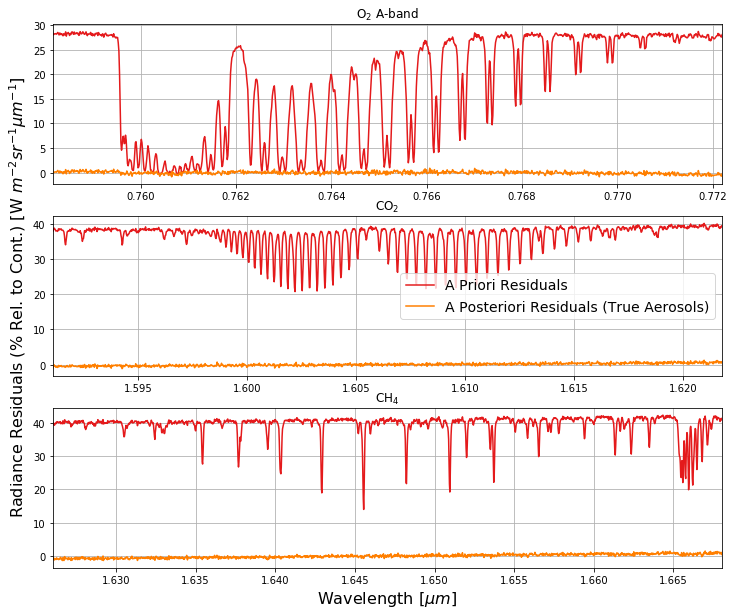

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(12,10))
ax[0].plot(model_true_with_aerosols.band_wl[0], (model_prior.R_band[0] - model_true_with_aerosols.R_band[0])/(model_true_with_aerosols.R_band[0].max())*100.,c='#e41a1c')
ax[0].plot(model_true_with_aerosols.band_wl[0], (model_ret_true_aerosols.R_band[0] - model_true_with_aerosols.R_band[0])/(model_true_with_aerosols.R_band[0].max())*100.,c='#ff7f00')
ax[0].set_xlim(min(model_true_with_aerosols.band_wl[0]),max(model_true_with_aerosols.band_wl[0]))
ax[0].set_title("O"+r'$_2$'+" A-band")
ax[0].grid(True)
ax[1].plot(model_true_with_aerosols.band_wl[1], (model_prior.R_band[1] - model_true_with_aerosols.R_band[1])/(model_true_with_aerosols.R_band[1].max())*100.,label="A Priori Residuals",c='#e41a1c')
ax[1].plot(model_true_with_aerosols.band_wl[1], (model_ret_true_aerosols.R_band[1] - model_true_with_aerosols.R_band[1])/(model_true_with_aerosols.R_band[1].max())*100.,label="A Posteriori Residuals (True Aerosols)",c='#ff7f00')
ax[1].set_xlim(min(model_true_with_aerosols.band_wl[1]),max(model_true_with_aerosols.band_wl[1]))
ax[1].set_ylabel('Radiance Residuals (% Rel. to Cont.) [W '+r'$m^{-2}$'+r'$ sr^{-1}$'+r'$\mu m^{-1}$'+']',size=16)
ax[1].set_title("CO"+r'$_2$')
ax[1].grid(True)
ax[1].legend(loc="center right",fontsize=14)
ax[2].plot(model_true_with_aerosols.band_wl[2], (model_prior.R_band[2] - model_true_with_aerosols.R_band[2])/(model_true_with_aerosols.R_band[2].max())*100.,c='#e41a1c')
ax[2].plot(model_true_with_aerosols.band_wl[2], (model_ret_true_aerosols.R_band[2] - model_true_with_aerosols.R_band[2])/(model_true_with_aerosols.R_band[2].max())*100.,c='#ff7f00')
ax[2].set_xlim(min(model_true_with_aerosols.band_wl[2]),max(model_true_with_aerosols.band_wl[2]))
ax[2].set_title("CH"+r'$_4$')
ax[2].set_xlabel('Wavelength ['+r'$\mu m$'+']',size=16)
ax[2].grid(True)

#### Plot the a posteriori correlation matrix:

Correlation matrix (R) condition number =  5.623


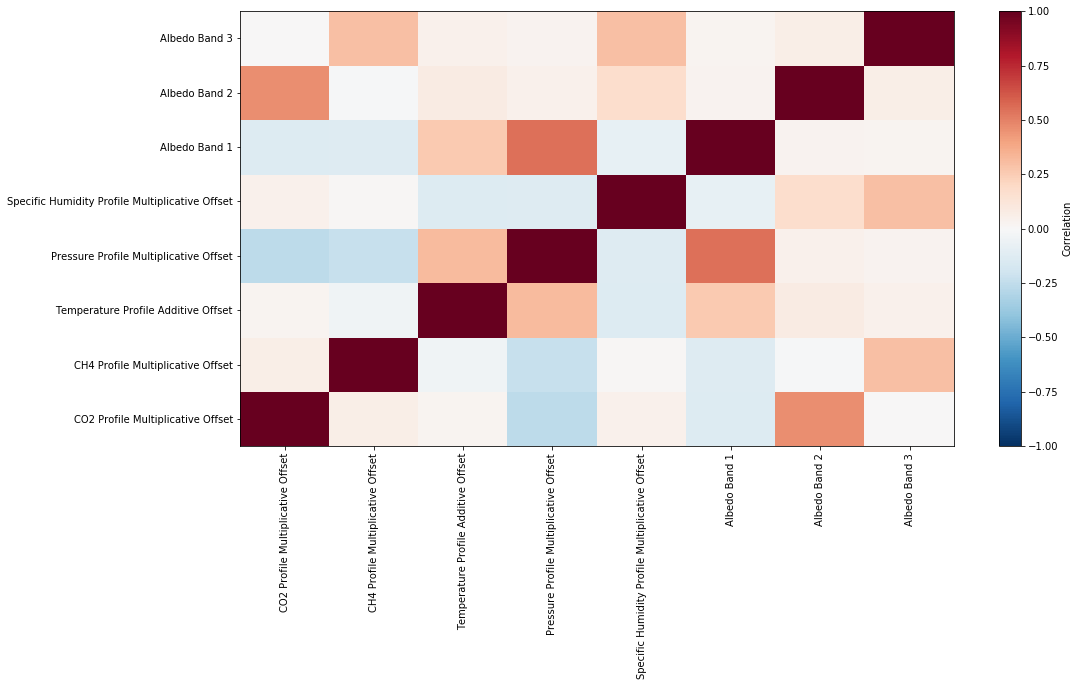

In [19]:
R_true_aerosols = np.zeros((len(x_true_aerosols["names"]),len(x_true_aerosols["names"])))
for i in range(len(x_true_aerosols["names"])):
  for j in range(len(x_true_aerosols["names"])):
    if i==j: R_true_aerosols[i,j] = 1
    else: R_true_aerosols[i,j] = ret_true_aerosols.S[i,j] / ret_true_aerosols.S[i,i]**0.5 / ret_true_aerosols.S[j,j]**0.5

fig = plt.figure(figsize=(16,8))
im1=plt.pcolormesh(R_true_aerosols,vmin=-1,vmax=1,cmap=plt.cm.RdBu_r)
plt.yticks(ticks=np.linspace(0.5,0.5*len(x_true_aerosols["names"])*2-0.5,len(x_true_aerosols["names"])),labels=x_true_aerosols["names"])
plt.xticks(ticks=np.linspace(0.5,0.5*len(x_true_aerosols["names"])*2-0.5,len(x_true_aerosols["names"])),labels=x_true_aerosols["names"], rotation=90)
cbar=plt.colorbar()
cbar.set_label("Correlation")

Eigs_true_aerosols = np.linalg.eigvals(R_true_aerosols)
cond_true_aerosols = np.max(Eigs_true_aerosols)/np.min(Eigs_true_aerosols)
print("Correlation matrix (R) condition number = ",'{:.3f}'.format(cond_true_aerosols))

#### Calculate and plot the averaging kernels for the gases:

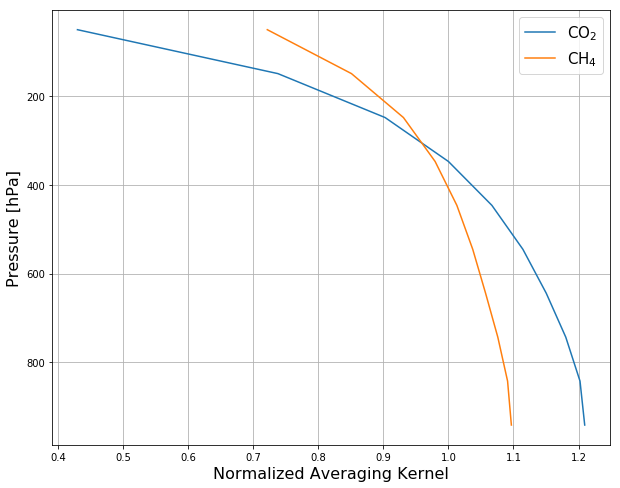

In [20]:
#Calculate the gain matrix
ret_true_aerosols.G = LA.inv((ret_true_aerosols.K.T).dot(model_true_with_aerosols.Sy_inv).dot(ret_true_aerosols.K) + LA.inv(x_true_aerosols["S_prior"])).dot(ret_true_aerosols.K.T).dot(model_true_with_aerosols.Sy_inv)

#Calculate the normalized gas averaging kernels
ret_true_aerosols.Ak_co2_norm = model_prior.xco2 * np.matmul(ret_true_aerosols.G[0,:],model_ret_true_aerosols.y_co2)/model_ret_true_aerosols.h *1e-6
ret_true_aerosols.Ak_ch4_norm = model_prior.xch4 * np.matmul(ret_true_aerosols.G[1,:],model_ret_true_aerosols.y_ch4)/model_ret_true_aerosols.h *1e-9

#Plot
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(ret_true_aerosols.Ak_co2_norm,model_prior.p_layer*x_true_aerosols["ret"][3]/100.,label="CO"+r'$_2$')
ax.plot(ret_true_aerosols.Ak_ch4_norm,model_prior.p_layer*x_true_aerosols["ret"][3]/100.,label="CH"+r'$_4$')
ax.set_xlabel("Normalized Averaging Kernel",size=16)
ax.set_ylabel("Pressure [hPa]",size=16)
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc="upper right",fontsize=15)

#### Things to ponder for (2):
*   What are the Xgas errors? Are they better or worse than (1)?
*   Is the final chisq close to unity?
*   What do the spectral residuals look like?
*   What do the retrieved state vector elements look like (e.g., albedo)?

#### (3) Now also retrieve aerosols:

In [21]:
model_prior_with_aerosols = ForwardFunction(
    absco_data=absco_data,
    P_aerosol=P_aerosol,
    ssa_aerosol=ssa_aerosol,
    qext_aerosol=qext_aerosol,
    co2=s.co2_prior,
    ch4=s.ch4_prior,
    T=s.T_prior,
    p=s.p_prior,
    q=s.q_prior,
    albedo=s.albedo_prior,
    tau_aerosol=s.tau_aerosol_prior
    )

#Add a tau_aerosol element to the state vector
x_true_aerosols_ret_aerosols = {}
x_true_aerosols_ret_aerosols["prior"] = np.append(x["prior"],model_prior_with_aerosols.tau_aerosol)
x_true_aerosols_ret_aerosols["names"] = deepcopy(x["names"])+["Aerosol Optical Depth"]
x_true_aerosols_ret_aerosols["true"] = np.append(x["true"],model_true_with_aerosols.tau_aerosol)
x_true_aerosols_ret_aerosols["S_prior"] = np.zeros((len(x["names"])+1,len(x["names"])+1))
x_true_aerosols_ret_aerosols["S_prior"][:len(x["names"]),:len(x["names"])] = deepcopy(x["S_prior"])
x_true_aerosols_ret_aerosols["S_prior"][len(x["names"]),len(x["names"])] = s.tau_aerosol_prior_uncert**2

ret_true_aerosols_ret_aerosols = Retrieval()
ret_true_aerosols_ret_aerosols.run(x_true_aerosols_ret_aerosols, model_prior_with_aerosols, model_true_with_aerosols, absco_data)

#Grab the radiances of the retrieved state for plotting
model_ret_true_aerosols_ret_aerosols = Retrieval.forward_model(ret_true_aerosols_ret_aerosols, x_true_aerosols_ret_aerosols, model_prior_with_aerosols, absco_data, jacobians=True)

-----------------------------------------------------------------------------------------------------------------------
State vector:
Name                                              Prior  True
CO2 Profile Multiplicative Offset                 1.0    1.0101010101010102  
CH4 Profile Multiplicative Offset                 1.0    0.9523809523809524  
Temperature Profile Additive Offset               0.0    -2.0                
Pressure Profile Multiplicative Offset            1.0    0.9803921568627451  
Specific Humidity Profile Multiplicative Offset   1.0    0.9523809523809523  
Albedo Band 1                                     0.22   0.2                 
Albedo Band 2                                     0.27   0.25                
Albedo Band 3                                     0.28   0.26                
Aerosol Optical Depth                             0.05   0.1                 
-----------
Reduced chisq =  6071.820659229435
Reduced chisq is not small enough yet, so update the st

#### Plot the residuals between the posterior modeled radiances and the true radiances

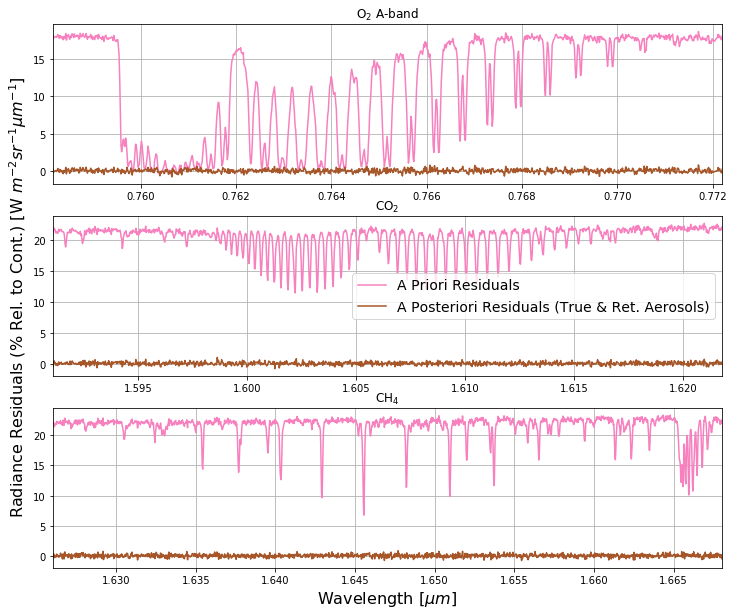

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(12,10))
ax[0].plot(model_true_with_aerosols.band_wl[0], (model_prior_with_aerosols.R_band[0] - model_true_with_aerosols.R_band[0])/(model_true_with_aerosols.R_band[0].max())*100.,c='#f781bf')
ax[0].plot(model_true_with_aerosols.band_wl[0], (model_ret_true_aerosols_ret_aerosols.R_band[0] - model_true_with_aerosols.R_band[0])/(model_true_with_aerosols.R_band[0].max())*100.,c='#a65628')
ax[0].set_xlim(min(model_true_with_aerosols.band_wl[0]),max(model_true_with_aerosols.band_wl[0]))
ax[0].set_title("O"+r'$_2$'+" A-band")
ax[0].grid(True)
ax[1].plot(model_true_with_aerosols.band_wl[1], (model_prior_with_aerosols.R_band[1] - model_true_with_aerosols.R_band[1])/(model_true_with_aerosols.R_band[1].max())*100.,label="A Priori Residuals",c='#f781bf')
ax[1].plot(model_true_with_aerosols.band_wl[1], (model_ret_true_aerosols_ret_aerosols.R_band[1] - model_true_with_aerosols.R_band[1])/(model_true_with_aerosols.R_band[1].max())*100.,label="A Posteriori Residuals (True & Ret. Aerosols)",c='#a65628')
ax[1].set_xlim(min(model_true_with_aerosols.band_wl[1]),max(model_true_with_aerosols.band_wl[1]))
ax[1].set_ylabel('Radiance Residuals (% Rel. to Cont.) [W '+r'$m^{-2}$'+r'$ sr^{-1}$'+r'$\mu m^{-1}$'+']',size=16)
ax[1].set_title("CO"+r'$_2$')
ax[1].grid(True)
ax[1].legend(loc="center right",fontsize=14)
ax[2].plot(model_true_with_aerosols.band_wl[2], (model_prior_with_aerosols.R_band[2] - model_true_with_aerosols.R_band[2])/(model_true_with_aerosols.R_band[2].max())*100.,c='#f781bf')
ax[2].plot(model_true_with_aerosols.band_wl[2], (model_ret_true_aerosols_ret_aerosols.R_band[2] - model_true_with_aerosols.R_band[2])/(model_true_with_aerosols.R_band[2].max())*100.,c='#a65628')
ax[2].set_xlim(min(model_true_with_aerosols.band_wl[2]),max(model_true_with_aerosols.band_wl[2]))
ax[2].set_title("CH"+r'$_4$')
ax[2].set_xlabel('Wavelength ['+r'$\mu m$'+']',size=16)
ax[2].grid(True)

#### Plot the posterior correlation matrix:

Correlation matrix (R) condition number =  20101.842


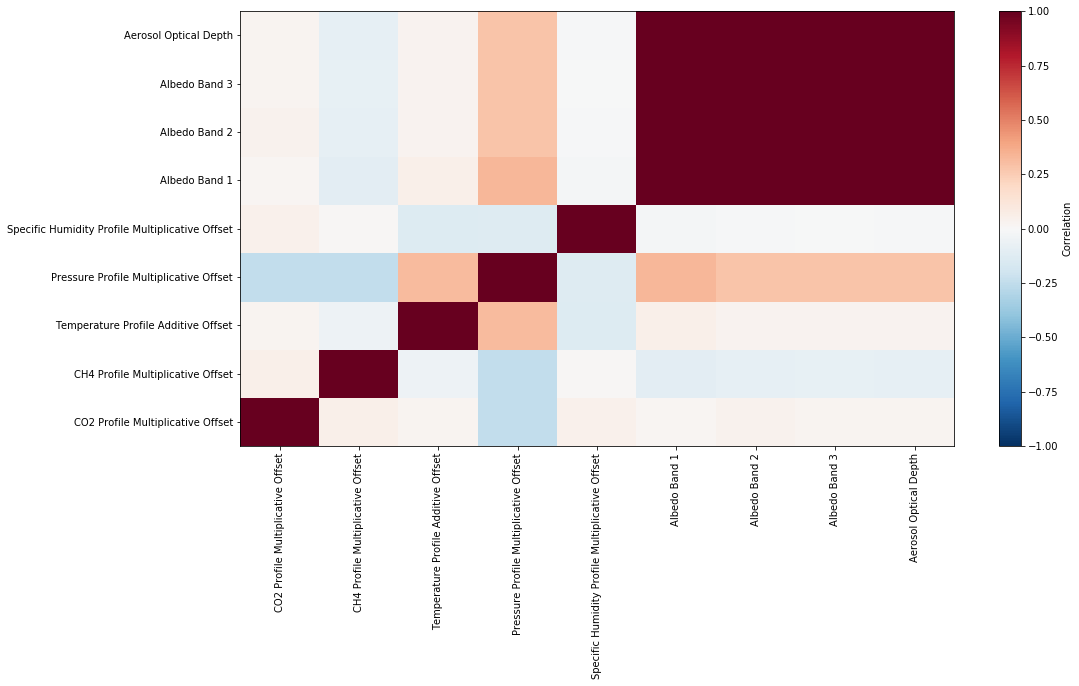

In [23]:
R_true_aerosols_ret_aerosols = np.zeros((len(x_true_aerosols_ret_aerosols["names"]),len(x_true_aerosols_ret_aerosols["names"])))
for i in range(len(x_true_aerosols_ret_aerosols["names"])):
  for j in range(len(x_true_aerosols_ret_aerosols["names"])):
    if i==j: R_true_aerosols_ret_aerosols[i,j] = 1
    else: R_true_aerosols_ret_aerosols[i,j] = ret_true_aerosols_ret_aerosols.S[i,j] / ret_true_aerosols_ret_aerosols.S[i,i]**0.5 / ret_true_aerosols_ret_aerosols.S[j,j]**0.5

fig = plt.figure(figsize=(16,8))
im1=plt.pcolormesh(R_true_aerosols_ret_aerosols,vmin=-1,vmax=1,cmap=plt.cm.RdBu_r)
plt.yticks(ticks=np.linspace(0.5,0.5*len(x_true_aerosols_ret_aerosols["names"])*2-0.5,len(x_true_aerosols_ret_aerosols["names"])),labels=x_true_aerosols_ret_aerosols["names"])
plt.xticks(ticks=np.linspace(0.5,0.5*len(x_true_aerosols_ret_aerosols["names"])*2-0.5,len(x_true_aerosols_ret_aerosols["names"])),labels=x_true_aerosols_ret_aerosols["names"], rotation=90)
cbar=plt.colorbar()
cbar.set_label("Correlation")

Eigs_true_aerosols_ret_aerosols = np.linalg.eigvals(R_true_aerosols_ret_aerosols)
cond_true_aerosols_ret_aerosols = np.max(Eigs_true_aerosols_ret_aerosols)/np.min(Eigs_true_aerosols_ret_aerosols)
print("Correlation matrix (R) condition number = ",'{:.3f}'.format(cond_true_aerosols_ret_aerosols))

#### Calculate and plot the averaging kernels for the gases:

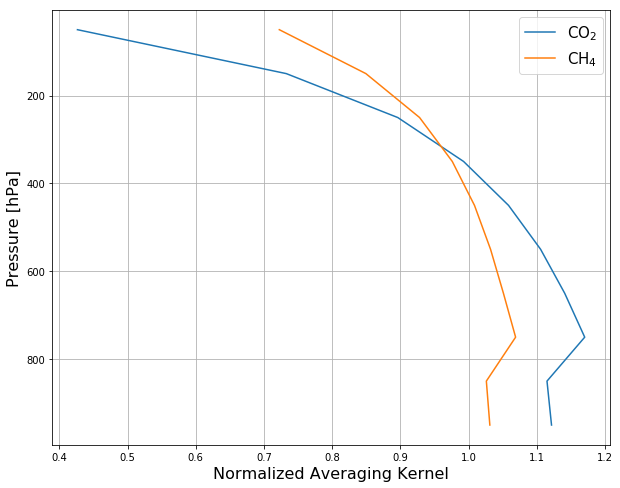

In [24]:
ret_true_aerosols_ret_aerosols.G = LA.inv((ret_true_aerosols_ret_aerosols.K.T).dot(model_true_with_aerosols.Sy_inv).dot(ret_true_aerosols_ret_aerosols.K) + LA.inv(x_true_aerosols_ret_aerosols["S_prior"])).dot(ret_true_aerosols_ret_aerosols.K.T).dot(model_true_with_aerosols.Sy_inv)

#Calculate the normalized gas averaging kernels
ret_true_aerosols_ret_aerosols.Ak_co2_norm = model_prior_with_aerosols.xco2 * np.matmul(ret_true_aerosols_ret_aerosols.G[0,:],model_ret_true_aerosols_ret_aerosols.y_co2)/model_ret_true_aerosols_ret_aerosols.h *1e-6
ret_true_aerosols_ret_aerosols.Ak_ch4_norm = model_prior_with_aerosols.xch4 * np.matmul(ret_true_aerosols_ret_aerosols.G[1,:],model_ret_true_aerosols_ret_aerosols.y_ch4)/model_ret_true_aerosols_ret_aerosols.h *1e-9

#Plot
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(ret_true_aerosols_ret_aerosols.Ak_co2_norm,model_prior_with_aerosols.p_layer*x_true_aerosols_ret_aerosols["ret"][3]/100.,label="CO"+r'$_2$')
ax.plot(ret_true_aerosols_ret_aerosols.Ak_ch4_norm,model_prior_with_aerosols.p_layer*x_true_aerosols_ret_aerosols["ret"][3]/100.,label="CH"+r'$_4$')
ax.set_xlabel("Normalized Averaging Kernel",size=16)
ax.set_ylabel("Pressure [hPa]",size=16)
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc="upper right",fontsize=15)

#### Things to ponder for (3):
*   What are the Xgas errors? Are they better or worse than (1,2)?
*   Is the final chisq close to unity?
*   Have the spectral residuals changed relative to (2)?
*   What do the retrieved state vector elements look like (e.g., albedo)?
*   What's going on with the posterior correlation matrix?
*   Have the AKs changed?

#### (4) Now do a retrieval, but try to retrieve a different aerosol type:

In [25]:
P_aerosol_dust, ssa_aerosol_dust, qext_aerosol_dust = mie_phase_function(d_aerosol=6e-6,n_aerosol=1.5+0.0006j)

model_prior_wrong_aerosol = ForwardFunction(
    absco_data=absco_data,
    P_aerosol=P_aerosol_dust, #Wrong aerosol
    ssa_aerosol=ssa_aerosol_dust, #Wrong aerosol
    qext_aerosol=qext_aerosol_dust, #Wrong aerosol
    co2=s.co2_prior,
    ch4=s.ch4_prior,
    T=s.T_prior,
    p=s.p_prior,
    q=s.q_prior,
    albedo=s.albedo_prior,
    tau_aerosol=s.tau_aerosol_prior
    )

x_wrong_aerosol = {}
x_wrong_aerosol["prior"] = deepcopy(x_true_aerosols_ret_aerosols["prior"])
x_wrong_aerosol["names"] = deepcopy(x_true_aerosols_ret_aerosols["names"])
x_wrong_aerosol["true"] = deepcopy(x_true_aerosols_ret_aerosols["true"])
x_wrong_aerosol["S_prior"] = deepcopy(x_true_aerosols_ret_aerosols["S_prior"])

ret_wrong_aerosol = Retrieval()
ret_wrong_aerosol.run(x_wrong_aerosol, model_prior_wrong_aerosol, model_true_with_aerosols, absco_data)

#Grab the radiances of the retrieved state for plotting
model_ret_wrong_aerosol = Retrieval.forward_model(ret_wrong_aerosol, x_wrong_aerosol, model_prior_wrong_aerosol, absco_data)

-----------------------------------------------------------------------------------------------------------------------
State vector:
Name                                              Prior  True
CO2 Profile Multiplicative Offset                 1.0    1.0101010101010102  
CH4 Profile Multiplicative Offset                 1.0    0.9523809523809524  
Temperature Profile Additive Offset               0.0    -2.0                
Pressure Profile Multiplicative Offset            1.0    0.9803921568627451  
Specific Humidity Profile Multiplicative Offset   1.0    0.9523809523809523  
Albedo Band 1                                     0.22   0.2                 
Albedo Band 2                                     0.27   0.25                
Albedo Band 3                                     0.28   0.26                
Aerosol Optical Depth                             0.05   0.1                 
-----------
Reduced chisq =  7721.356613931855
Reduced chisq is not small enough yet, so update the st

#### Plot the residuals between the posterior modeled radiances and the true radiances:

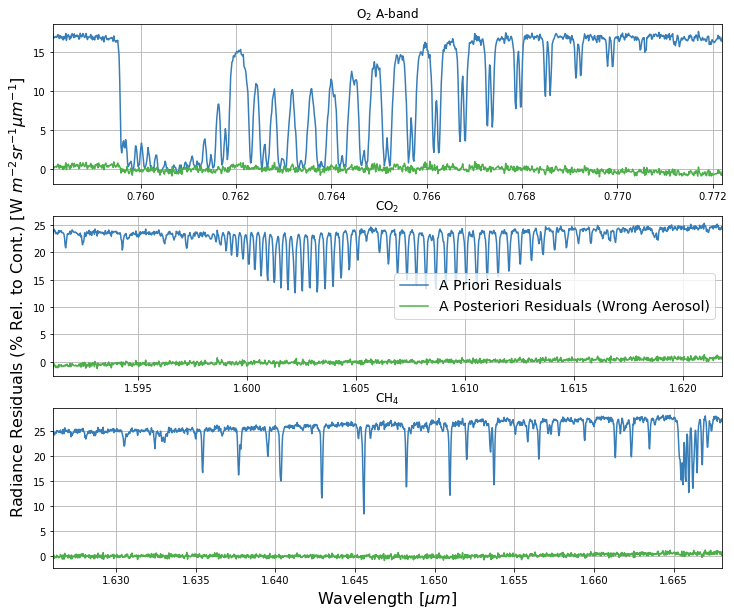

In [26]:
fig, ax = plt.subplots(3, 1, figsize=(12,10))
ax[0].plot(model_true_with_aerosols.band_wl[0], (model_prior_wrong_aerosol.R_band[0] - model_true_with_aerosols.R_band[0])/(model_true_with_aerosols.R_band[0].max())*100.,c='#377eb8')
ax[0].plot(model_true_with_aerosols.band_wl[0], (model_ret_wrong_aerosol.R_band[0] - model_true_with_aerosols.R_band[0])/(model_true_with_aerosols.R_band[0].max())*100.,c='#4daf4a')
ax[0].set_xlim(min(model_true_with_aerosols.band_wl[0]),max(model_true_with_aerosols.band_wl[0]))
ax[0].set_title("O"+r'$_2$'+" A-band")
ax[0].grid(True)
ax[1].plot(model_true_with_aerosols.band_wl[1], (model_prior_wrong_aerosol.R_band[1] - model_true_with_aerosols.R_band[1])/(model_true_with_aerosols.R_band[1].max())*100.,label="A Priori Residuals",c='#377eb8')
ax[1].plot(model_true_with_aerosols.band_wl[1], (model_ret_wrong_aerosol.R_band[1] - model_true_with_aerosols.R_band[1])/(model_true_with_aerosols.R_band[1].max())*100.,label="A Posteriori Residuals (Wrong Aerosol)",c='#4daf4a')
ax[1].set_xlim(min(model_true_with_aerosols.band_wl[1]),max(model_true_with_aerosols.band_wl[1]))
ax[1].set_ylabel('Radiance Residuals (% Rel. to Cont.) [W '+r'$m^{-2}$'+r'$ sr^{-1}$'+r'$\mu m^{-1}$'+']',size=16)
ax[1].set_title("CO"+r'$_2$')
ax[1].grid(True)
ax[1].legend(loc="center right",fontsize=14)
ax[2].plot(model_true_with_aerosols.band_wl[2], (model_prior_wrong_aerosol.R_band[2] - model_true_with_aerosols.R_band[2])/(model_true_with_aerosols.R_band[2].max())*100.,c='#377eb8')
ax[2].plot(model_true_with_aerosols.band_wl[2], (model_ret_wrong_aerosol.R_band[2] - model_true_with_aerosols.R_band[2])/(model_true_with_aerosols.R_band[2].max())*100.,c='#4daf4a')
ax[2].set_xlim(min(model_true_with_aerosols.band_wl[2]),max(model_true_with_aerosols.band_wl[2]))
ax[2].set_title("CH"+r'$_4$')
ax[2].set_xlabel('Wavelength ['+r'$\mu m$'+']',size=16)
ax[2].grid(True)

#### Things to ponder for (4):
*   What are the Xgas errors? Are they better or worse than previous tests?
*   Is the final chisq close to unity?
*   What do the spectral residuals look like?
*   What do the retrieved state vector elements look like (e.g., tau_aerosol, albedo)?

#### (5) Now do a retrieval, but have the prior aerosol height be wrong:

In [27]:
model_prior_wrong_height = ForwardFunction(
    absco_data=absco_data,
    P_aerosol=P_aerosol,
    ssa_aerosol=ssa_aerosol,
    qext_aerosol=qext_aerosol,
    co2=s.co2_prior,
    ch4=s.ch4_prior,
    T=s.T_prior,
    p=s.p_prior,
    q=s.q_prior,
    albedo=s.albedo_prior,
    tau_aerosol=s.tau_aerosol_prior,
    height_aerosol=10000 #Wrong aerosol height
    )

x_wrong_height = {}
x_wrong_height["prior"] = deepcopy(x_true_aerosols_ret_aerosols["prior"])
x_wrong_height["names"] = deepcopy(x_true_aerosols_ret_aerosols["names"])
x_wrong_height["true"] = deepcopy(x_true_aerosols_ret_aerosols["true"])
x_wrong_height["S_prior"] = deepcopy(x_true_aerosols_ret_aerosols["S_prior"])

ret_wrong_height = Retrieval()
ret_wrong_height.run(x_wrong_height, model_prior_wrong_height, model_true_with_aerosols, absco_data)

#Grab the radiances of the retrieved state for plotting
model_ret_wrong_height = Retrieval.forward_model(ret_wrong_height, x_wrong_height, model_prior_wrong_height, absco_data)

-----------------------------------------------------------------------------------------------------------------------
State vector:
Name                                              Prior  True
CO2 Profile Multiplicative Offset                 1.0    1.0101010101010102  
CH4 Profile Multiplicative Offset                 1.0    0.9523809523809524  
Temperature Profile Additive Offset               0.0    -2.0                
Pressure Profile Multiplicative Offset            1.0    0.9803921568627451  
Specific Humidity Profile Multiplicative Offset   1.0    0.9523809523809523  
Albedo Band 1                                     0.22   0.2                 
Albedo Band 2                                     0.27   0.25                
Albedo Band 3                                     0.28   0.26                
Aerosol Optical Depth                             0.05   0.1                 
-----------
Reduced chisq =  6141.710923395916
Reduced chisq is not small enough yet, so update the st

#### Plot the residuals between the posterior modeled radiances and the true radiances:

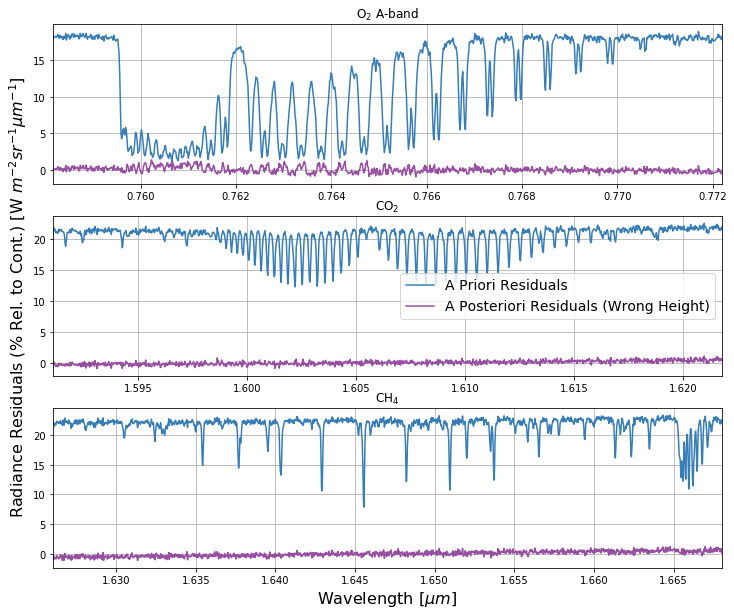

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(12,10))
ax[0].plot(model_true_with_aerosols.band_wl[0], (model_prior_wrong_height.R_band[0] - model_true_with_aerosols.R_band[0])/(model_true_with_aerosols.R_band[0].max())*100.,c='#377eb8')
ax[0].plot(model_true_with_aerosols.band_wl[0], (model_ret_wrong_height.R_band[0] - model_true_with_aerosols.R_band[0])/(model_true_with_aerosols.R_band[0].max())*100.,c='#984ea3')
ax[0].set_xlim(min(model_true_with_aerosols.band_wl[0]),max(model_true_with_aerosols.band_wl[0]))
ax[0].set_title("O"+r'$_2$'+" A-band")
ax[0].grid(True)
ax[1].plot(model_true_with_aerosols.band_wl[1], (model_prior_wrong_height.R_band[1] - model_true_with_aerosols.R_band[1])/(model_true_with_aerosols.R_band[1].max())*100.,label="A Priori Residuals",c='#377eb8')
ax[1].plot(model_true_with_aerosols.band_wl[1], (model_ret_wrong_height.R_band[1] - model_true_with_aerosols.R_band[1])/(model_true_with_aerosols.R_band[1].max())*100.,label="A Posteriori Residuals (Wrong Height)",c='#984ea3')
ax[1].set_xlim(min(model_true_with_aerosols.band_wl[1]),max(model_true_with_aerosols.band_wl[1]))
ax[1].set_ylabel('Radiance Residuals (% Rel. to Cont.) [W '+r'$m^{-2}$'+r'$ sr^{-1}$'+r'$\mu m^{-1}$'+']',size=16)
ax[1].set_title("CO"+r'$_2$')
ax[1].grid(True)
ax[1].legend(loc="center right",fontsize=14)
ax[2].plot(model_true_with_aerosols.band_wl[2], (model_prior_wrong_height.R_band[2] - model_true_with_aerosols.R_band[2])/(model_true_with_aerosols.R_band[2].max())*100.,c='#377eb8')
ax[2].plot(model_true_with_aerosols.band_wl[2], (model_ret_wrong_height.R_band[2] - model_true_with_aerosols.R_band[2])/(model_true_with_aerosols.R_band[2].max())*100.,c='#984ea3')
ax[2].set_xlim(min(model_true_with_aerosols.band_wl[2]),max(model_true_with_aerosols.band_wl[2]))
ax[2].set_title("CH"+r'$_4$')
ax[2].set_xlabel('Wavelength ['+r'$\mu m$'+']',size=16)
ax[2].grid(True)

#### Things to ponder for (5):
*   What are the Xgas errors? Are they better or worse than previous tests?
*   How do these results differ from (4)?

#### (6) Proxy $X_{\mathrm{CH_4}}$ retrieval:
*   Assuming no scattering by aerosols, but make sure the true scene has aerosols!
*   Retrieve $N_{\mathrm{CO_2}}$ using just the CO$_2$ band and retrieve $N_{\mathrm{CH_4}}$ using just the CH$_4$ band, then calculate $N_{\mathrm{CO_2}}$/$N_{\mathrm{CH_4}}$ and multiple by some estimate of the true $X_{\mathrm{CO_2}}$ to get $X_{\mathrm{CH_4}}$.

In [29]:
model_prior_proxy_co2 = ForwardFunction(
    absco_data=absco_data,
    P_aerosol=P_aerosol[1:2], #Only the CO2 band
    ssa_aerosol=ssa_aerosol[1:2], #Only the CO2 band
    qext_aerosol=qext_aerosol[1:2], #Only the CO2 band
    co2=s.co2_prior,
    ch4=np.zeros(len(s.ch4_prior)),
    T=s.T_prior,
    p=s.p_prior,
    q=s.q_prior,
    tau_aerosol=None, #Don't include tau_aerosol
    albedo=s.albedo_prior[1:2], #Only the CO2 band
    band_min_um=s.band_min_um[1:2], #Only the CO2 band
    band_max_um=s.band_max_um[1:2], #Only the CO2 band
    band_min_wn=s.band_min_wn[1:2], #Only the CO2 band
    band_max_wn=s.band_max_wn[1:2], #Only the CO2 band
    band_molecules=s.band_molecules[1:2], #Only the CO2 band
    band_spectral_points=s.band_spectral_points[1:2], #Only the CO2 band
    band_wn=s.band_wn[1:2], #Only the CO2 band
    band_wl=s.band_wl[1:2], #Only the CO2 band
    band_absco_res_wn=s.band_absco_res_wn[1:2], #Only the CO2 band
    resolving_power_band=s.resolving_power_band[1:2], #Only the CO2 band
    sigma_band=s.sigma_band[1:2], #Only the CO2 band
    band_wn_index=s.band_wn_index[1:2], #Only the CO2 band
    ILS_Gaussian_term=s.ILS_Gaussian_term[1:2], #Only the CO2 band
    ILS_Gaussian_term_sum=s.ILS_Gaussian_term_sum[1:2] #Only the CO2 band
    )

#Copy the original state vector, except only use the CO2 band and don't include tau_aerosol
x_proxy_co2 = {}
indices = [0,2,3,4,6]
x_temp = deepcopy(x)
x_proxy_co2["prior"] = np.array([x_temp["prior"][i] for i in indices])
x_proxy_co2["names"] = [x_temp["names"][i] for i in indices]
x_proxy_co2["true"] = np.array([x_temp["true"][i] for i in indices])
x_proxy_co2["S_prior"] = np.array(x_temp["S_prior"][np.ix_(indices,indices)])

#Also hack together the true radiances for the CO2 band
model_true_proxy_co2 = deepcopy(model_true_with_aerosols)
model_true_proxy_co2.y = model_true_proxy_co2.y[model_true_proxy_co2.band_spectral_points[0]:model_true_proxy_co2.band_spectral_points[0]+model_true_proxy_co2.band_spectral_points[1]]
model_true_proxy_co2.Sy_inv = model_true_proxy_co2.Sy_inv[model_true_proxy_co2.band_spectral_points[0]:model_true_proxy_co2.band_spectral_points[0]+model_true_proxy_co2.band_spectral_points[1],model_true_proxy_co2.band_spectral_points[0]:model_true_proxy_co2.band_spectral_points[0]+model_true_proxy_co2.band_spectral_points[1]]

#Pass our prior without aerosols, but the true state with aerosols
ret_proxy_co2 = Retrieval()
ret_proxy_co2.run(x_proxy_co2, model_prior_proxy_co2, model_true_proxy_co2, absco_data)

#Grab retrieved radiances
model_ret_proxy_co2 = Retrieval.forward_model(ret_proxy_co2, x_proxy_co2, model_prior_proxy_co2, absco_data)

#Number of dry air molecules per cubic meter (number density)
model_ret_proxy_co2.n_dry_air = calculate_n_dry_air(model_ret_proxy_co2.p_diff, model_ret_proxy_co2.q_layer)

#Number of CO2 molecules per cubic meter (number density)
model_ret_proxy_co2.n_co2 = model_ret_proxy_co2.n_dry_air * model_ret_proxy_co2.co2_layer

-----------------------------------------------------------------------------------------------------------------------
State vector:
Name                                              Prior  True
CO2 Profile Multiplicative Offset                 1.0    1.0101010101010102  
Temperature Profile Additive Offset               0.0    -2.0                
Pressure Profile Multiplicative Offset            1.0    0.9803921568627451  
Specific Humidity Profile Multiplicative Offset   1.0    0.9523809523809523  
Albedo Band 2                                     0.27   0.25                
-----------
Reduced chisq =  21690.842396489457
Reduced chisq is not small enough yet, so update the state vector
Updated state vector (iteration 1):
Name                                             Prior  True                  Current               Dx from prev. iteration:
CO2 Profile Multiplicative Offset                1.0    1.0101010101010102    1.024917613076946     0.024917613076945955
Temperature Profil

#### Then, do the $\mathrm{CH_4}$-only retrieval:

In [30]:
model_prior_proxy_ch4 = ForwardFunction(
    absco_data=absco_data,
    P_aerosol=P_aerosol[2:], #Only the CH4 band
    ssa_aerosol=ssa_aerosol[2:], #Only the CH4 band
    qext_aerosol=qext_aerosol[2:], #Only the CH4 band
    co2=np.zeros(len(s.co2_prior)),
    ch4=s.ch4_prior,
    T=s.T_prior,
    p=s.p_prior,
    q=s.q_prior,
    tau_aerosol=None, #Don't include tau_aerosol
    albedo=s.albedo_prior[2:], #Only the CH4 band
    band_min_um=s.band_min_um[2:], #Only the CH4 band
    band_max_um=s.band_max_um[2:], #Only the CH4 band
    band_min_wn=s.band_min_wn[2:], #Only the CH4 band
    band_max_wn=s.band_max_wn[2:], #Only the CH4 band
    band_spectral_resolutions=s.band_spectral_resolutions[2:], #Only the CH4 band
    band_spectral_points=s.band_spectral_points[2:], #Only the CH4 band
    band_molecules=s.band_molecules[2:], #Only the CH4 band
    band_wn=s.band_wn[2:], #Only the CH4 band
    band_wl=s.band_wl[2:], #Only the CH4 band
    band_absco_res_wn=s.band_absco_res_wn[2:], #Only the CH4 band
    resolving_power_band=s.resolving_power_band[2:], #Only the CH4 band
    sigma_band=s.sigma_band[2:], #Only the CH4 band
    band_wn_index=s.band_wn_index[2:], #Only the CH4 band
    ILS_Gaussian_term=s.ILS_Gaussian_term[2:], #Only the CH4 band
    ILS_Gaussian_term_sum=s.ILS_Gaussian_term_sum[2:] #Only the CH4 band
    )

#Copy the original state vector, except only use the CH4 band and don't include tau_aerosol
x_proxy_ch4 = {}
indices = [1,2,3,4,7]
x_temp = deepcopy(x)
x_proxy_ch4["prior"] = np.array([x_temp["prior"][i] for i in indices])
x_proxy_ch4["names"] = [x_temp["names"][i] for i in indices]
x_proxy_ch4["true"] = np.array([x_temp["true"][i] for i in indices])
x_proxy_ch4["S_prior"] = np.array(x_temp["S_prior"][np.ix_(indices,indices)])

#Also hack together the true radiances for the CO2 band
model_true_proxy_ch4 = deepcopy(model_true_with_aerosols)
model_true_proxy_ch4.y = model_true_proxy_ch4.y[model_true_proxy_ch4.band_spectral_points[0]+model_true_proxy_ch4.band_spectral_points[1]:]
model_true_proxy_ch4.Sy_inv = model_true_proxy_ch4.Sy_inv[model_true_proxy_ch4.band_spectral_points[0]+model_true_proxy_ch4.band_spectral_points[1]:,model_true_proxy_ch4.band_spectral_points[0]+model_true_proxy_ch4.band_spectral_points[1]:,]

#Pass our prior without aerosols, but the true state with aerosols
ret_proxy_ch4 = Retrieval()
ret_proxy_ch4.run(x_proxy_ch4, model_prior_proxy_ch4, model_true_proxy_ch4, absco_data)

#Grab retrieved radiances
model_ret_proxy_ch4 = Retrieval.forward_model(ret_proxy_ch4, x_proxy_ch4, model_prior_proxy_ch4, absco_data)

#Number of dry air molecules per cubic meter (number density)
model_ret_proxy_ch4.n_dry_air = calculate_n_dry_air(model_ret_proxy_ch4.p_diff, model_ret_proxy_ch4.q_layer)

#Number of CH4 molecules per cubic meter (number density)
model_ret_proxy_ch4.n_ch4 = model_ret_proxy_ch4.n_dry_air * model_ret_proxy_ch4.ch4_layer

-----------------------------------------------------------------------------------------------------------------------
State vector:
Name                                              Prior  True
CH4 Profile Multiplicative Offset                 1.0    0.9523809523809524  
Temperature Profile Additive Offset               0.0    -2.0                
Pressure Profile Multiplicative Offset            1.0    0.9803921568627451  
Specific Humidity Profile Multiplicative Offset   1.0    0.9523809523809523  
Albedo Band 3                                     0.28   0.26                
-----------
Reduced chisq =  24962.66774727034
Reduced chisq is not small enough yet, so update the state vector
Updated state vector (iteration 1):
Name                                             Prior  True                  Current               Dx from prev. iteration:
CH4 Profile Multiplicative Offset                1.0    0.9523809523809524    0.8620454965089444    -0.13795450349105565
Temperature Profile

#### Proxy method for estimating $X_{\mathrm{CH_4}}$:

In [31]:
xch4_proxy = (np.sum(model_ret_proxy_ch4.n_ch4) / np.sum(model_ret_proxy_co2.n_co2)) * model_prior.xco2*1e-6 *1e9 #To ppb
print("True XCH4 =",'{:.5f}'.format(model_true.xch4),"ppb")
print("Proxy XCH4 (using prior XCO2) =",'{:.5f}'.format(xch4_proxy),"ppb")
print("Proxy XCH4 (error using prior XCO2) =",'{:.5f}'.format(xch4_proxy - model_true.xch4),"ppb")

True XCH4 = 1789.70357 ppb
Proxy XCH4 (using prior XCO2) = 1754.29215 ppb
Proxy XCH4 (error using prior XCO2) = -35.41142 ppb


#### Or, instead of using the a priori $X_{\mathrm{CO_2}}$, pretend we know the true $X_{\mathrm{CO_2}}$:

In [32]:
xch4_proxy_using_true_xco2 = (np.sum(model_ret_proxy_ch4.n_ch4) / np.sum(model_ret_proxy_co2.n_co2)) * model_true.xco2*1e-6 *1e9 #To ppb
print("True XCH4 =",'{:.5f}'.format(model_true.xch4),"ppb")
print("Proxy XCH4 (using true XCO2) =",'{:.5f}'.format(xch4_proxy_using_true_xco2),"ppb")
print("Proxy XCH4 (error using true XCO2) =",'{:.5f}'.format(xch4_proxy_using_true_xco2 - model_true.xch4),"ppb")

True XCH4 = 1789.70357 ppb
Proxy XCH4 (using true XCO2) = 1772.01254 ppb
Proxy XCH4 (error using true XCO2) = -17.69103 ppb


Text(0.5, 0, 'Wavelength [$\\mu m$]')

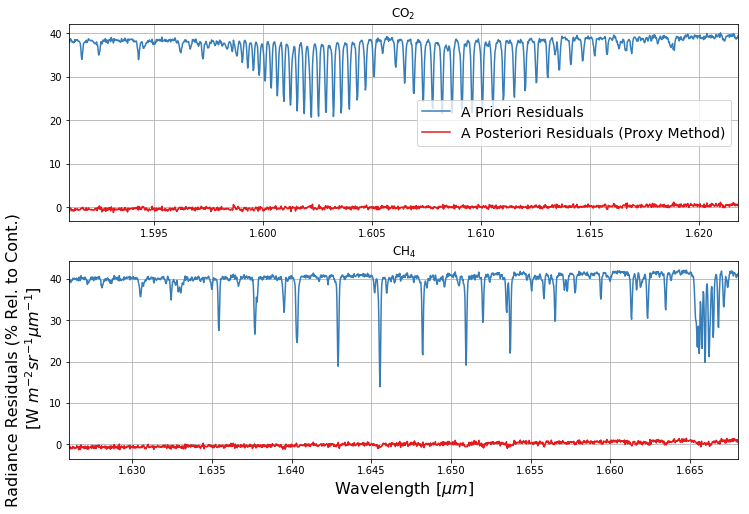

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(model_prior_proxy_co2.band_wl[0], (model_prior_proxy_co2.R_band[0] - model_true_proxy_co2.R_band[1])/(model_true_proxy_co2.R_band[1].max())*100.,label="A Priori Residuals",c='#377eb8')
ax[0].plot(model_prior_proxy_co2.band_wl[0], (model_ret_proxy_co2.R_band[0] - model_true_proxy_co2.R_band[1])/(model_true_proxy_co2.R_band[1].max())*100.,label="A Posteriori Residuals (Proxy Method)",c='#e41a1c')
ax[0].set_title("CO"+r'$_2$')
ax[0].set_xlim(min(model_prior_proxy_co2.band_wl[0]),max(model_prior_proxy_co2.band_wl[0]))
ax[0].grid(True)
ax[0].legend(loc="center right",fontsize=14)
ax[1].plot(model_prior_proxy_ch4.band_wl[0], (model_prior_proxy_ch4.R_band[0] - model_true_proxy_ch4.R_band[2])/(model_true_proxy_ch4.R_band[2].max())*100.,c='#377eb8')
ax[1].plot(model_prior_proxy_ch4.band_wl[0], (model_ret_proxy_ch4.R_band[0] - model_true_proxy_ch4.R_band[2])/(model_true_proxy_ch4.R_band[2].max())*100.,c='#e41a1c')
ax[1].set_xlim(min(model_prior_proxy_ch4.band_wl[0]),max(model_prior_proxy_ch4.band_wl[0]))
ax[1].set_ylabel('Radiance Residuals (% Rel. to Cont.)\n [W '+r'$m^{-2}$'+r'$ sr^{-1}$'+r'$\mu m^{-1}$'+']',size=16)
ax[1].set_title("CH"+r'$_4$')
ax[1].grid(True)
ax[1].set_xlabel('Wavelength ['+r'$\mu m$'+']',size=16)

#### Things to ponder for (6):
*   How does the proxy XCH4 retrieval compare to the full physics retrieval?

#### Ideas for additional tests:
*   Either improve or degrade the SNR (in settings.py) and rerun the notebook. How do the Xgas errors change?
*   Either improve or degrade the band spectral resolution (in settings.py). How do the Xgas errors change? How do the AKs change?
*   What happens if your prior Xgas is way off the true Xgas? (E.g., co2=s.co2_prior*0.5)